In [40]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import tensorflow 
from tensorflow import keras
import segmentation_models as sm
from segmentation_models import Unet
import glob
from patchify import patchify

In [2]:
CLASSES = ['road',
        'sidewalk',
        'construction',
        'tram-track',
        'fence',
        'pole',
        'traffic-light',
        'traffic-sign',
        'vegetation',
        'terrain',
        'sky',
        'human',
        'rail-track',
        'car',
        'truck',
        'trackbed',
        'on-rails',
        'rail-raised',
        'rail-embedded']

In [48]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [49]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []

for directory_path in glob.glob('rs19_val/jpgs/rs19_val/'):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob('rs19_val/uint8/rs19_val/'):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [50]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [54]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss='binary_crossentropy', metrics=[sm.metrics.iou_score],)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [58]:
history= model.fit(x_train,y_train,
   batch_size=12,
   epochs=8,
   verbose=1,
   validation_data=(x_val, y_val))

#accuracy = model.evaluate(x_val, y_val)

Epoch 1/8
567/567 [==============================] - 791s 1s/step - loss: -47540.0078 - iou_score: 17.0642 - val_loss: -58611.1758 - val_iou_score: 17.2930
Epoch 2/8
567/567 [==============================] - 784s 1s/step - loss: -77367.3281 - iou_score: 17.0685 - val_loss: -102871.4766 - val_iou_score: 17.2930
Epoch 3/8
567/567 [==============================] - 792s 1s/step - loss: -115376.8828 - iou_score: 17.0680 - val_loss: -154612.7969 - val_iou_score: 17.2930
Epoch 4/8
567/567 [==============================] - 795s 1s/step - loss: -157585.7656 - iou_score: 17.0620 - val_loss: -199012.2969 - val_iou_score: 17.2930
Epoch 5/8
567/567 [==============================] - 796s 1s/step - loss: -207670.8594 - iou_score: 17.0620 - val_loss: -282564.2188 - val_iou_score: 17.2930
Epoch 6/8
567/567 [==============================] - 795s 1s/step - loss: -262928.5938 - iou_score: 17.0661 - val_loss: -336499.4688 - val_iou_score: 17.2930
Epoch 7/8
567/567 [==============================] - 79

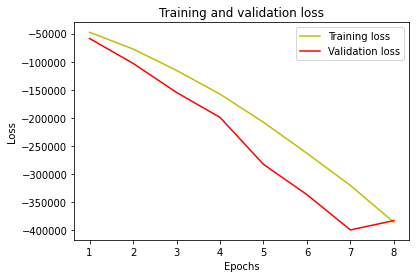

In [59]:
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## splitting

In [30]:
#these codes are used to loop through the directory
path_images = 'rs19_val/uint8/rs19_val'

breaker = 0

list_tram=[]
list_tram_w_veg=[]

list_train=[]
list_train_w_veg=[]


for filename in os.listdir(path_images):
    #breaker +=1
    if filename.endswith('.png'):    
        mask = cv2.imread('rs19_val/uint8/rs19_val/'+filename) 
        labels = np.unique(mask[:,:,0]) 
        if (3 in labels) and (13 in labels):
            list_tram.append(filename)
            if 8 in labels:
                list_tram_w_veg.append(filename)
        else:
            list_train.append(filename)
            if 8 in labels:
                list_train_w_veg.append(filename)

    # if len(list_tram) == 10:
    #     break

In [31]:
#Convert list to array for machine learning processing        
tram_images_mask = np.array(list_tram)
tram_images_veg_mask = np.array(list_tram_w_veg)

train_images_mask = np.array(list_train)
train_images_veg_mask = np.array(list_train_w_veg)

In [45]:
tram_images_veg_mask.shape

(1459,)

In [47]:
tram_images_veg_mask

array(['rs00001.png', 'rs00003.png', 'rs00006.png', ..., 'rs08490.png',
       'rs08493.png', 'rs08496.png'], dtype='<U11')

In [41]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val'

breaker = 0

list_tram=[]
list_tram_w_veg=[]

list_train=[]
list_train_w_veg=[]

for filename in os.listdir(path_images):
    #breaker +=1
    if filename.endswith('.jpg'):    
        mask = cv2.imread('rs19_val/jpgs/rs19_val/'+filename) 
        labels = np.unique(mask[:,:,0]) 
        if (3 in labels) and (13 in labels):
            list_tram.append(filename)
            if 8 in labels:
                list_tram_w_veg.append(filename)
        else:
            list_train.append(filename)
            if 8 in labels:
                list_train_w_veg.append(filename)

    # if len(list_tram) == 10:
    #     break

In [42]:
#Convert list to array for machine learning processing        
tram_images = np.array(list_tram)
tram_images_veg = np.array(list_tram_w_veg)

train_images = np.array(list_train)
train_images_veg = np.array(list_train_w_veg)

In [46]:
tram_images_veg.shape

(6799,)

In [ ]:
#Use customary x_train and y_train variables
X = tram_images
Y = tram_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 

In [8]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
